In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import os 
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
from IPython import display
from IPython.display import Image
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dense, Reshape, BatchNormalization, ReLU, Concatenate, Activation, LeakyReLU, Dropout, Flatten
from tensorflow.keras.models import Model


/Users/benbradshaw/Documents/Coding/2023/AC-GAN-mnist/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.2.2
charset-normalizer           3.3.2
click                        8.1.7
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
dm-tree                      0.1.8
etils                        1.8.0
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.51.0
fsspec                       2024.5.0
gast                         0.5.4
google-pasta                 0.2.0
googleapis-common-protos     1.63.0
grpcio                       1.63.0
h5py                         3.11.0
idna                         3.7
importlib_resources          6.4.0
ipykernel                    6.29.4


# Configurations

In [37]:
class CFG:
    latent_dim=100
    num_classes=10
    noise_dim=100
    batch_size=32
    train_size=40000
    num_batches=1500

# Data Extraction and Preprocessing

In [52]:
train_ds, val_ds, test_ds = tfds.load('mnist', split=['train[:80%]', 'train[80%:]', 'test'], as_supervised=True)

In [53]:
def preprocessing(features, labels):

    features = tf.cast(features, tf.float32)

    features = (features / 127.5) - 1

    labels = tf.keras.utils.to_categorical(labels, CFG.num_classes)

    return features, labels


AUTO = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(preprocessing, num_parallel_calls=AUTO)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(batch_size=CFG.batch_size)

## Generator and Discriminator

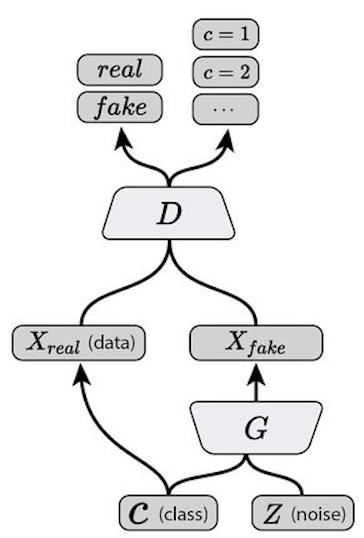

In [54]:
# Display an image file
Image(filename='example.png')

In [108]:
def build_generator():

    noise = Input(shape=(CFG.noise_dim,))
    label = Input(shape=(CFG.num_classes,))

    inputs = Concatenate()([noise, label])

    x = Dense(units=128*7*7, activation='relu')(inputs)
    x = Reshape(target_shape=(7,7,128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(filters=1, kernel_size=3, padding='same')(x)
    outputs = Activation(activation='tanh')(x)

    model = Model(inputs=[noise, label], outputs=outputs, name='AC-GAN-Gen')

    return model


def build_discriminator():
    
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dropout(rate=0.25)(x)

    flatten = Flatten()(x)

    validity = Dense(units=1, activation='sigmoid', name='valid_dense')(flatten)
    label = Dense(units=CFG.num_classes, activation='softmax', name='label_dense')(flatten)
    
    model = Model(inputs=inputs, outputs=[validity, label], name='AC-Gan-Disc')

    return model



In [109]:
generator = build_generator()

discriminator = build_discriminator()

In [110]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.zeros_like(real_output), real_output)
    total_loss = fake_loss + real_loss
    return total_loss

In [111]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Loss functions
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
sparse_categorical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output, labels, pred):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    classifier_loss = sparse_categorical_cross_entropy(labels, pred)

    total_loss = real_loss + fake_loss + classifier_loss
    return total_loss

def generator_loss(fake_output, fake_labels, fake_pred):

    fake_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)
    classifier_loss = sparse_categorical_cross_entropy(fake_labels, fake_pred)

    total_loss = fake_loss + classifier_loss

    return total_loss




In [112]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    axes = axes.flatten() 
    
    for i in range(predictions.shape[0]):
        axes[i].imshow(predictions[i, :, :, 0] * 127.5, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title('Class: '+str(i%10), fontsize=8)

    if (epoch+1) % 10 == 0:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

    plt.tight_layout(pad=0.5)
    plt.show()

def plot_loss(gen_loss, disc_loss):

	# Adding loss to train loss file
	if os.path.isfile('train_loss.csv'):
		df = pd.read_csv('train_loss.csv')
	else:
		df = pd.DataFrame(columns=['gen_loss', 'disc_loss'])
	print(gen_loss, disc_loss)
	new_row = {'gen_loss':gen_loss, 'disc_loss':disc_loss}
	df.loc[len(df)] = new_row
	print(df)
	
	plt.plot(df.index, df['gen_loss'], label='gen loss', color='blue')
	plt.plot(df.index, df['disc_loss'], label='disc loss', color='red')
	plt.title('Training Loss')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()
	plt.show()
	
	df.to_csv('train_loss.csv', index=False)

    


In [113]:
@tf.function
def train_step(image, label):
    noise = tf.random.normal([CFG.batch_size, CFG.noise_dim])
    noise_label_ = tf.random.uniform([CFG.batch_size],
                                        minval=0,
                                        maxval=9,
                                        dtype=tf.dtypes.int64)
                                        
    noise_label = tf.one_hot(noise_label_,10)
    seed = [noise,noise_label]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_images = generator(seed, training=False)

        real_output, real_pred = discriminator(image, training=True)
        fake_output, fake_pred = discriminator(gen_images, training=True)

        gen_loss = generator_loss(fake_output, noise_label, fake_pred)
        disc_loss = discriminator_loss(real_output, fake_output, label, fake_pred)        

    gen_grad = gen_tape.gradient(gen_loss,generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Checkpoints

In [114]:
checkpoint_dir = './acgan_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training Process

In [115]:
seed_image = tf.random.normal([16, CFG.noise_dim])
seed_label = tf.one_hot([i%10 for i in range(16)], 10)
seed = [seed_image, seed_label]

In [116]:
def train(dataset, epochs, checkpoint_restore):

	if checkpoint_restore:
		checkpoint_weights = tf.train.latest_checkpoint(checkpoint_dir)
		if checkpoint_weights:
			checkpoint.restore(checkpoint_weights)
			print("Checkpoint restored from", checkpoint_weights)
		else:
			print("No checkpoint found.")

	for epoch in range(epochs):
		start = time.time()
		for image, label in tqdm(dataset):
			gen_loss, disc_loss = train_step(image, label)
			gen_loss, disc_loss = gen_loss.numpy(), disc_loss.numpy()
		
		
		display.clear_output(wait=True)
		generate_and_save_images(generator,epoch+1,seed)
		plot_loss(gen_loss=gen_loss, disc_loss=disc_loss)

		if (epoch+1) % 10 == 0:
			checkpoint.save(file_prefix=checkpoint_prefix)
			print(f"Checkpoint saved at epoch {epoch + 1}")
		
		print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

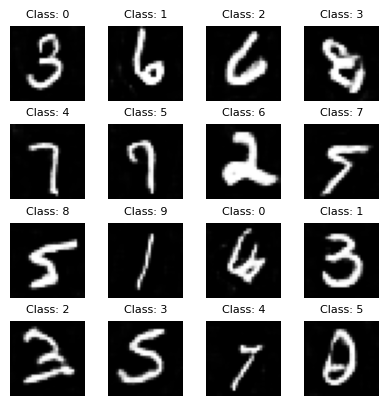

3.2292194 3.4257004
   gen_loss  disc_loss
0  4.166142   3.344837
1  4.512345   3.553422
2  3.896290   3.297098
3  3.412749   3.328999
4  4.735258   3.720154
5  5.182388   3.021645
6  3.638098   3.429783
7  3.752981   3.660560
8  3.001882   3.470686
9  3.229219   3.425700


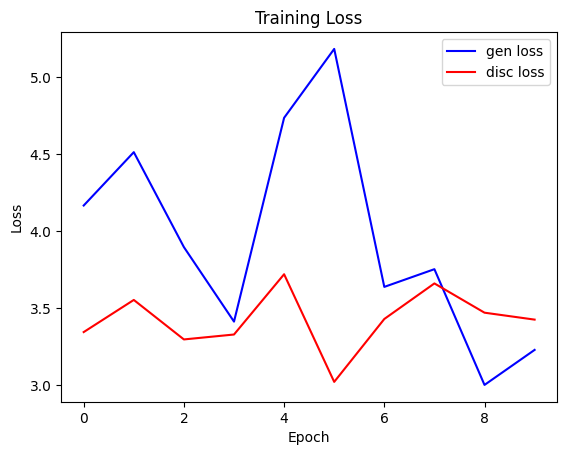

Checkpoint saved at epoch 10
Time for epoch 10 is 191.31092524528503 sec


In [117]:
train(train_ds, 10, False)